
# Gathering the Data

# 1. Read input files

In [39]:
import time
import math
import pandas as pd
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.data_utils import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

#get tickers that are in tiingo and GFD
ticker_info = Database.query("SELECT b.* from ticker_index_membership b "
                             "inner join tiingo_tickers a on a.ticker = b.ticker "
                             "where b.equity_index = 'S&P500' "
                             "and b.endDate = '2023-04-21 00:00:00.000000' and b.startDate < '2010-01-01 00:00:00.000000'")

['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [76]:
wrds_imputation_name = "univariate"
universe = 'SP'
iterative_imputer = True
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

In [41]:
#find a valid time period for the assets
startDate = ticker_info.startDate.min()
endDate = ticker_info.endDate.min()
ticker_info['ticker_currency'] = ticker_info.ticker + "-" + ticker_info.priceCurrency

In [42]:
tickers = tuple(ticker_info.ticker.unique())
len(ticker_info['ticker_currency'].unique())
len(tickers)

555

In [43]:
monthly_adjClose, adjClose = get_monthly_adjusted_price(tickers, start_date = startDate, end_date = endDate, Database = Database, return_daily=True)

In [44]:
monthly_adjusted_volumes, adjVolume = get_monthly_adjusted(tickers, start_date = startDate, end_date = endDate,
                                                                        Database = Database, return_daily=True, data_column = 'adjVolume')

C:\Users\david\PycharmProjects\support_vector_risk_machine\services\data_retreival.py:33: UserWarning: IMPORTANT: The monthly aggregation returned in the dataframe is only the last observation
  warnings.warn("IMPORTANT: The monthly aggregation returned in the dataframe is only the last observation")


<AxesSubplot:xlabel='date'>

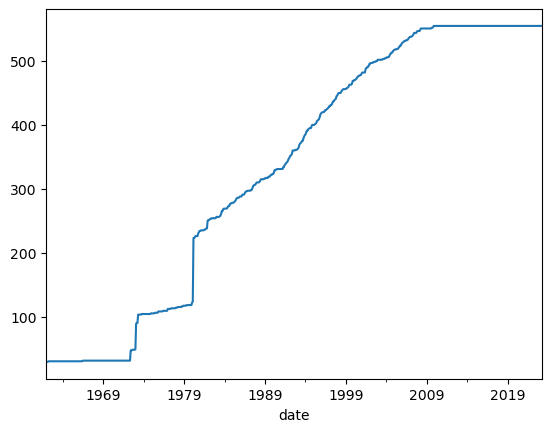

In [45]:
(~monthly_adjClose.isna()).sum(axis = 1).plot()

In [46]:
dates_idx = (~monthly_adjClose.isna()).sum(axis = 1) >= 400
data_start_date = dates_idx[dates_idx].index[0] # - pd.offsets.MonthEnd() + pd.offsets.DateOffset(days=1)
number_of_missing = monthly_adjClose[dates_idx].isna().sum(axis = 0)
clean_tickers = number_of_missing[number_of_missing == 0]

print("Number of tickers with no monthly observations missing ", len(clean_tickers))
print("Number of monthly dates ", sum(dates_idx))

Number of tickers with no monthly observations missing  400
Number of monthly dates  342


In [47]:
idx = pd.IndexSlice
filtered_cols_idx = idx[:, clean_tickers.index.get_level_values('ticker')]
monthly_adjClose_phase1 = monthly_adjClose.loc[dates_idx, filtered_cols_idx]
monthly_adjusted_volumes_phase1 = monthly_adjusted_volumes.loc[dates_idx,  filtered_cols_idx]

In [48]:
adjClose_phase1 = adjClose.loc[adjClose.index >= data_start_date, filtered_cols_idx]
adjVolume_phase1 = adjVolume.loc[adjVolume.index >= data_start_date, filtered_cols_idx]

                   adjClose
date       ticker          
1994-12-08 IEX     4.093170
2007-07-02 JCI     3.199171
1997-01-10 FMCC    3.105914
1994-12-01 MCK     2.441683
1995-02-01 IEX     2.403614
1996-11-04 MCO     2.191522
2009-08-10 FMCC    1.283784
1996-06-03 URBN    1.112360
2021-11-02 CAR     1.083110
2007-02-23 TRMB    1.000000
1995-05-22 AN      1.000000
2009-03-20 CAR     0.981818
2023-02-06 BBBY    0.921311
2008-09-08 FNMA    0.896307
1999-04-19 MAYS    0.890634
2002-07-29 WMB     0.877358
2018-02-14 FOSL    0.877212
2021-01-27 FOSL    0.870356
2008-10-13 MS      0.869835
2008-09-08 FMCC    0.827451


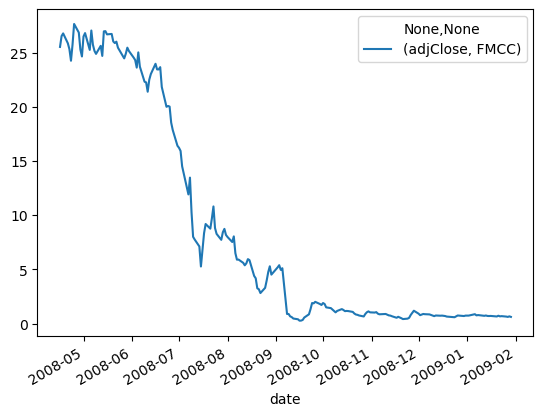

In [49]:
k = 20
top_k_returns = adjClose_phase1.pct_change(1).dropna().stack().abs().sort_values(by = 'adjClose', ascending = False).iloc[:k]
date, ticker = top_k_returns.index[k-1]

show_data_around_time(adjClose_phase1, ticker, date, pds = 100)

tickers_that_are_too_vol = top_k_returns.index.get_level_values('ticker').unique()

print(top_k_returns)

date
1994-11-30    1.535125
1994-12-31    8.057023
1995-01-31    1.588075
1995-02-28    5.548697
1995-03-31    5.717071
1995-04-30    6.417842
1995-05-31    6.537047
1995-06-30    6.440914
1995-07-31    8.467411
1995-08-31    7.766939
1995-09-30    6.898586
1995-10-31    7.311358
1995-11-30    7.965991
1995-12-31    7.892393
1996-01-31    7.388153
1996-02-29    7.120818
1996-03-31    7.728397
1996-04-30    7.637596
1996-05-31    7.369183
1996-06-30    7.393584
1996-07-31    5.881208
1996-08-31    7.228985
1996-09-30    6.518339
1996-10-31    7.313017
1996-11-30    7.757215
1996-12-31    7.853737
1997-01-31    7.421305
1997-02-28    7.534109
1997-03-31    6.976027
1997-04-30    7.829214
1997-05-31    8.762755
Name: (adjClose, IEX), dtype: float64

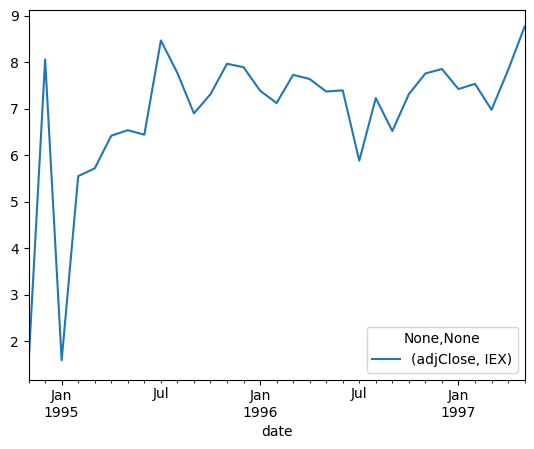

In [50]:
top_k_returns = monthly_adjClose_phase1.pct_change(1).dropna().stack().abs().sort_values(by = 'adjClose', ascending = False).iloc[:k]
date, ticker = top_k_returns.index[0]

show_data_around_time(monthly_adjClose_phase1, ticker, date, pds = 30)

In [51]:
# no na's
adjClose_phase1.isna().sum()[adjClose_phase1.isna().sum() > 0]

Series([], dtype: int64)

In [52]:
# no na's
adjVolume_phase1.isna().sum().sum()

0

# WRDS

In [53]:
#fundamentals sources
source_info = Database.query("SELECT * from source_id")

In [54]:
fundamentals_info = Database.query("SELECT b.* from fundamentals b "
                             "where b.source = 'wrds'")

In [55]:
fundamentals_info.date = pd.to_datetime(fundamentals_info.date, format='%Y-%m-%d')

In [56]:
fundamentals_info_filtered = fundamentals_info[fundamentals_info.date >= data_start_date]

In [57]:
ticker_currency_df = pd.DataFrame(ticker_info['ticker_currency'].unique(), columns = ['ticker_currency'])

fundamentals_info_ticker_filtered = fundamentals_info_filtered.merge(ticker_currency_df, on = 'ticker_currency', how = 'inner')

In [58]:
fundamentals_info_ticker_filtered[['ticker', 'currency']] = fundamentals_info_ticker_filtered.ticker_currency.str.split('-', expand=True)

In [59]:
fundamentals_pivoted = fundamentals_info_ticker_filtered.pivot(index=['date', 'ticker'], columns='metric', values='value')

# Ticker Filtering Here

In [81]:
common_tickers = intersection(monthly_adjClose_phase1.columns.get_level_values(1), fundamentals_pivoted.index.get_level_values(1).unique())
common_tickers = list(set(common_tickers) - set(tickers_that_are_too_vol))
len(common_tickers)

365

In [82]:
indices = fundamentals_pivoted.index.get_level_values('date') <= start_date
subsetted_index = fundamentals_pivoted.index[indices]
common_tickers = intersection(common_tickers, subsetted_index.get_level_values('ticker'))

In [83]:
len(common_tickers)

289

In [84]:
# for consistent ordering
common_tickers.sort()

In [85]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

if iterative_imputer:
    imp_mean = IterativeImputer(random_state=0)
else:
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
fundamentals_dfs = []
idx = pd.IndexSlice
cols = list(fundamentals_pivoted.columns)
fundamentals_dates = fundamentals_pivoted.index.get_level_values(0).unique()

for dt in fundamentals_dates:
    df_to_append = fundamentals_pivoted.loc[idx[dt,common_tickers], cols]
    df_to_append = df_to_append.dropna(axis=1, how='all')
    if cols != list(df_to_append.columns):
        print("Number of columns dropped", len(cols) - len(df_to_append.columns))
    cols = list(df_to_append.columns)
    imp_mean.fit(df_to_append)
    transformed_df = imp_mean.transform(df_to_append)
    transformed_df = pd.DataFrame(transformed_df, columns = df_to_append.columns, index = df_to_append.index)
    fundamentals_dfs.append(transformed_df)


Number of columns dropped 2


In [86]:
fundamentals_out = pd.concat([df.loc[:, cols] for df in fundamentals_dfs])

In [87]:
#check the dates for wrds and monthly returns (they are the same)
len(intersection(monthly_adjClose_phase1.index, fundamentals_dates)) == min(len(monthly_adjClose_phase1.index), len(fundamentals_dates))

True

# Export WRDS Monthly Prices Daily Prices

In [88]:
idx = pd.IndexSlice
monthly_adjClose_phase1.loc[:, idx[:, common_tickers]].to_csv("flat_files/MonthlyAssetPrices"+universe +".csv")
adjClose_phase1.loc[:, idx[:, common_tickers]].to_csv("flat_files/DailyAssetPrices"+universe +".csv")
fundamentals_out.to_csv("flat_files/MultivariateWRDS.csv")

# Technicals Volume and Price

In [89]:
# construct the earliest possible test start date
k_values = [20, 40, 60, 120, 250, 500]
k_max = max(k_values)
monthly_dates = monthly_adjClose_phase1.index[monthly_adjClose_phase1.index >= adjClose_phase1.index[k_max]]

In [90]:
technical_analysis_rets = get_k_rolling_stats(adjClose_phase1.pct_change(1).dropna(), monthly_dates, k_values=k_values)

technical_analysis_volume = get_k_rolling_stats(adjVolume_phase1, monthly_dates, k_values=k_values)

In [91]:
technical_analysis_rets.columns = ["adjRet_"+ col for col in technical_analysis_rets.columns]
technical_analysis_volume.columns = ["adjVolume_"+ col for col in technical_analysis_volume.columns]

In [92]:
technical_analysis = pd.concat([technical_analysis_rets, technical_analysis_volume], axis = 1)

In [93]:
idx = pd.IndexSlice
technical_analysis.loc[idx[:, common_tickers], :].to_csv("flat_files/TechnicalAnalysis"+universe + ".csv")